# Import & Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the current directory
current_dir = os.path.abspath('')

# Add the src directory to the system path
src_path = os.path.join(current_dir, 'src')
sys.path.insert(0, src_path)

from pathlib import Path
from preprocessing_reviews import preprocessing_review as pr

In [2]:
path_to_data = Path.cwd() / "data/IMDB-movie-reviews.csv"

In [3]:
reviews = pd.read_csv(filepath_or_buffer=path_to_data,
                      header=0,
                      sep=";",
                      encoding="latin-1")

## Exploring - Cleaning - Transforming

In [37]:
# Check the "reviews" dataframe
reviews.head(n=30)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [5]:
print(f"The Longest review in characters? {max(reviews['review'].apply(lambda review: len(review)))}")

The Longest review in characters? 4009


In [6]:
# HTML Tags Removal
reviews['review'] = reviews['review'].apply(lambda review: pr.remove_html_tags(review))

In [7]:
# Insights
print(f"The longest review in characters after removing HTML tags and useless spaces? {max(reviews['review'].apply(lambda review: len(review)))}")

The longest review in characters after removing HTML tags and useless spaces? 3973


In [8]:
(reviews['sentiment'].value_counts() / len(reviews) * 100)

sentiment
negative    58.0
positive    42.0
Name: count, dtype: float64

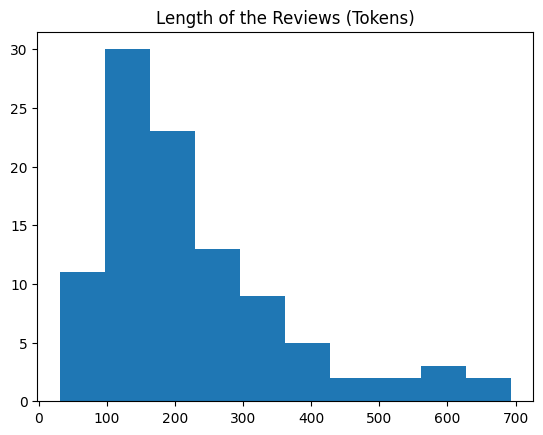

In [9]:
# Visualization
length_reviews_as_tokens = [len(review.split()) for review in reviews['review'].tolist()]
counts, values, _ = plt.hist(length_reviews_as_tokens)
_ = plt.title("Length of the Reviews (Tokens)")

The maximal number of "tokens" for a given review seems to be between 650 and 700. However the volume of such reviews is low. Let's see how many of them have a length higher than 512.

In [10]:
print(f"Maximal number of tokens in a review? {int(max(values))} tokens")

Maximal number of tokens in a review? 693 tokens


In [11]:
print(f"Proportion of reviews with more than 512 tokens? {np.round(np.sum(reviews['review'].apply(lambda review: len(review.split())) > 512) / len(reviews['review']) * 100, 2)}%")

Proportion of reviews with more than 512 tokens? 7.0%


In [12]:
reviews['sentiment'] = reviews['sentiment'].apply(lambda sentiment: pr.convert_target_variable(sentiment))

In [13]:
# Last check
reviews.head(n= 10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [14]:
(reviews['sentiment'].value_counts()/len(reviews['sentiment'])) * 100

sentiment
0    58.0
1    42.0
Name: count, dtype: float64

# Benchmark Evaluation

In [15]:
# Use a pipeline as a high-level helper
from transformers import pipeline

/Users/arnaudgueulette/projects_@2024/SentimentAnalysisProject/.SentimentAnalysisHuggingFace/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SiEBERT Model

In [16]:
# SiEBERT - https://huggingface.co/siebert/sentiment-roberta-large-english
pipeline_SiEBERT = pipeline("text-classification",
                             model="siebert/sentiment-roberta-large-english")

In [17]:
predictions_SiEBERT = pipeline_SiEBERT(reviews['review'].tolist(),
                                       max_length=512,
                                       truncation=True,
                                       padding=True)

In [18]:
predictions_SiEBERT = pd.DataFrame(predictions_SiEBERT)
predictions_SiEBERT.columns = ['SiEBERT_pred_sentiment', 'SiEBERT_score']
predictions_SiEBERT['SiEBERT_pred_sentiment'] = predictions_SiEBERT['SiEBERT_pred_sentiment'].apply(lambda pred_sentiment: pr.convert_target_variable(pred_sentiment))

## DeBERTa-v2 Kaludi Model

In [19]:
# DeBERTa-v2 Kaludi Model - https://huggingface.co/Kaludi/Reviews-Sentiment-Analysis
pipeline_deBERTa = pipeline("text-classification",
                            model="Kaludi/Reviews-Sentiment-Analysis")

In [20]:
predictions_deBERTa = pipeline_deBERTa(reviews['review'].tolist(),
                                       max_length=512,
                                       truncation=True,
                                       padding=True)

In [21]:
predictions_deBERTa = pd.DataFrame(predictions_deBERTa)
predictions_deBERTa.columns = ['deBERTa_pred_sentiment', 'deBERTa_score']
predictions_deBERTa['deBERTa_pred_sentiment'] = predictions_deBERTa['deBERTa_pred_sentiment'].apply(lambda pred_sentiment: pr.convert_target_variable(pred_sentiment))

## Results Analysis

In [22]:
results = pd.concat([reviews, predictions_SiEBERT, predictions_deBERTa],
                    ignore_index=True,
                    axis = 1)

results.columns = ['review', 'true_sentiment','SiEBERT_pred_sentiment', 'SiEBERT_score','deBERTa_pred_sentiment', 'deBERTa_score']

In [23]:
results

,review,true_sentiment,SiEBERT_pred_sentiment,SiEBERT_score,deBERTa_pred_sentiment,deBERTa_score
0,One of the other reviewers has mentioned that ...,1,1,0.998805,1,0.992541
1,A wonderful little production. The filming tec...,1,1,0.998936,1,0.994760
2,I thought this was a wonderful way to spend ti...,1,1,0.998932,1,0.994600
3,Basically there's a family where a little boy ...,0,0,0.999490,0,0.992297
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1,0.998886,1,0.994778
...,...,...,...,...,...,...
95,Daniel Day-Lewis is the most versatile actor a...,1,1,0.998918,1,0.994705
96,My guess would be this was originally going to...,0,0,0.999513,0,0.992594
97,"Well, I like to watch bad horror B-Movies, cau...",0,0,0.999502,0,0.993925
98,"This IS the worst movie I have ever seen, as w...",0,0,0.999515,0,0.993955


### SiEBERT

In [24]:
results[results['true_sentiment'] != results['SiEBERT_pred_sentiment']]

,review,true_sentiment,SiEBERT_pred_sentiment,SiEBERT_score,deBERTa_pred_sentiment,deBERTa_score
11,I saw this movie when I was about 12 when it c...,0,1,0.994920,0,0.849301
16,Some films just simply should not be remade. T...,1,0,0.998360,1,0.976676
25,The Karen Carpenter Story shows a little more ...,1,0,0.980850,1,0.974059
51,"***SPOILERS*** All too, in real life as well a...",1,0,0.979734,1,0.780553
70,Caddyshack Two is a good movie by itself but c...,0,1,0.996044,0,0.937699


In [25]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(results['true_sentiment'], results['SiEBERT_pred_sentiment']))

[[56  2]
 [ 3 39]]


In [26]:
from sklearn.metrics import classification_report

print(classification_report(results['true_sentiment'], results['SiEBERT_pred_sentiment']))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        58
           1       0.95      0.93      0.94        42

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



### DeBerta-v2

In [27]:
results[results['true_sentiment'] != results['deBERTa_pred_sentiment']]

,review,true_sentiment,SiEBERT_pred_sentiment,SiEBERT_score,deBERTa_pred_sentiment,deBERTa_score
67,I really like Salman Kahn so I was really disa...,0,0,0.99922,1,0.812355


In [28]:
print(confusion_matrix(results['true_sentiment'], results['deBERTa_pred_sentiment']))

[[57  1]
 [ 0 42]]


In [29]:
print(classification_report(results['true_sentiment'], results['deBERTa_pred_sentiment']))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        42

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

